#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

### Загрузка и базовая проверка данных

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.index.is_monotonic

True

***Вывод:*** данные в порядке, пропусков нет, выпонена проверка на монотонность.

### Ресеплирование 

Выполним ресемплирование по одному часу.

In [5]:
df = df.resample('1H').sum()

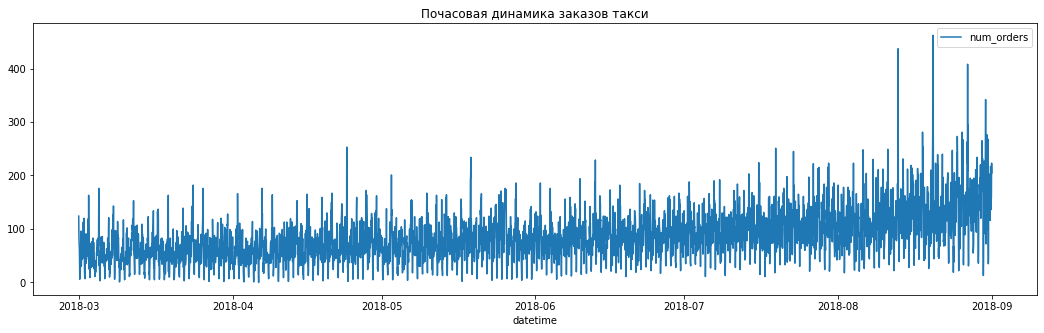

In [6]:
plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=df))
plt.title("Почасовая динамика заказов такси")
plt.show()

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ

Разложим временной ряд на на тренд, сезонность и остаток.

In [7]:
decomposed = seasonal_decompose(df)

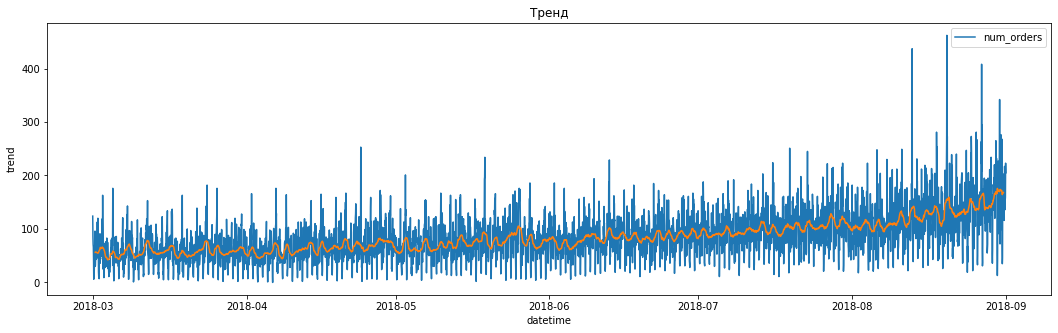

In [8]:
plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=df))
plt.subplot(sns.lineplot(data=decomposed.trend))
plt.title("Тренд")
plt.show()

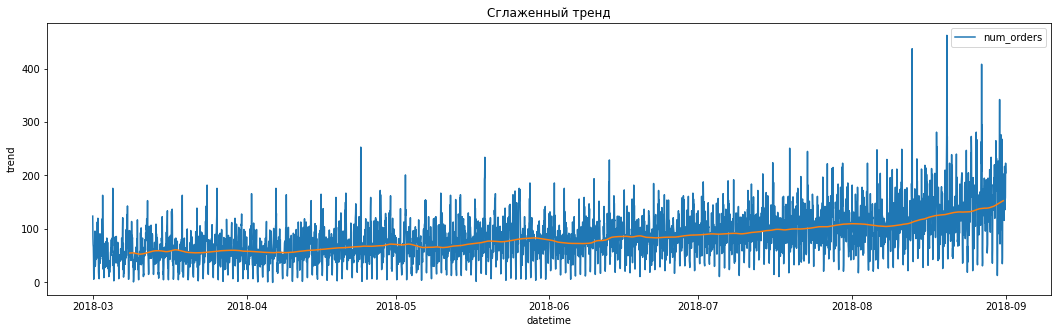

In [9]:
#пройдемся недельным окном (24*7)
plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=df))
plt.subplot(sns.lineplot(data=decomposed.trend.rolling(168).mean()))
plt.title("Сглаженный тренд")
plt.show()

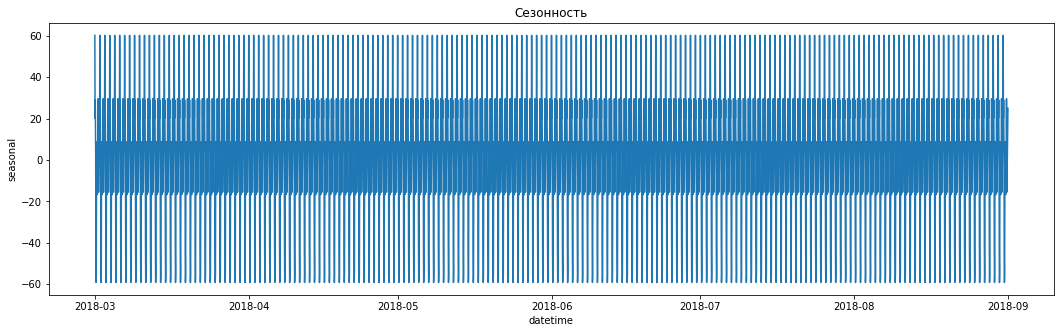

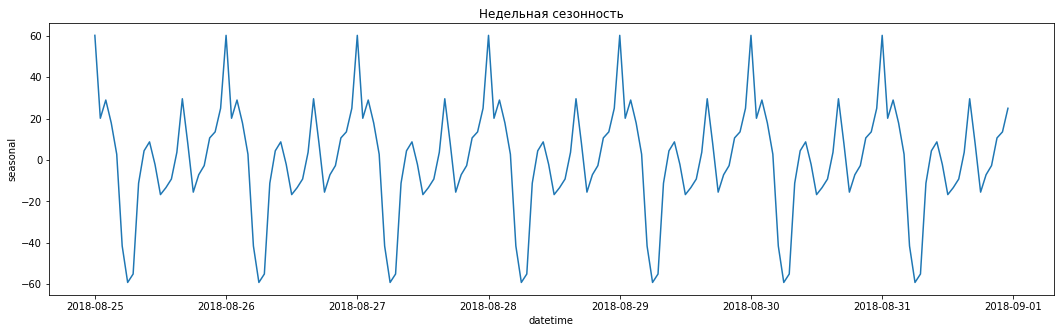

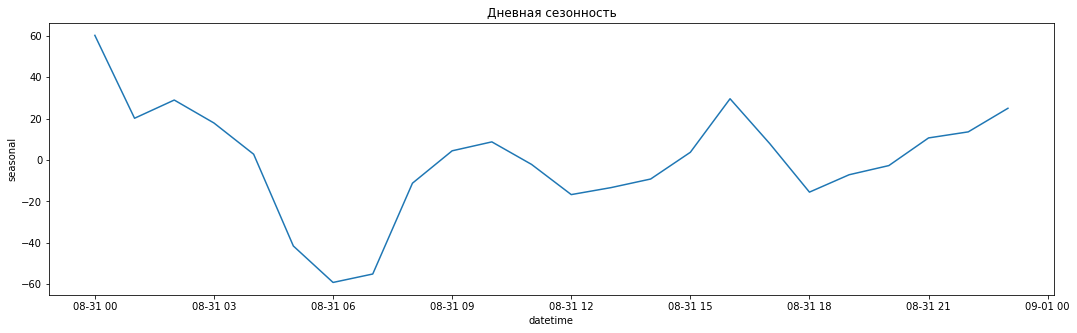

In [10]:
plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=decomposed.seasonal))
plt.title("Сезонность")
plt.show()

plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=decomposed.seasonal.tail(24*7)))
plt.title("Недельная сезонность")
plt.show()

plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=decomposed.seasonal.tail(24)))
plt.title("Дневная сезонность")
plt.show()

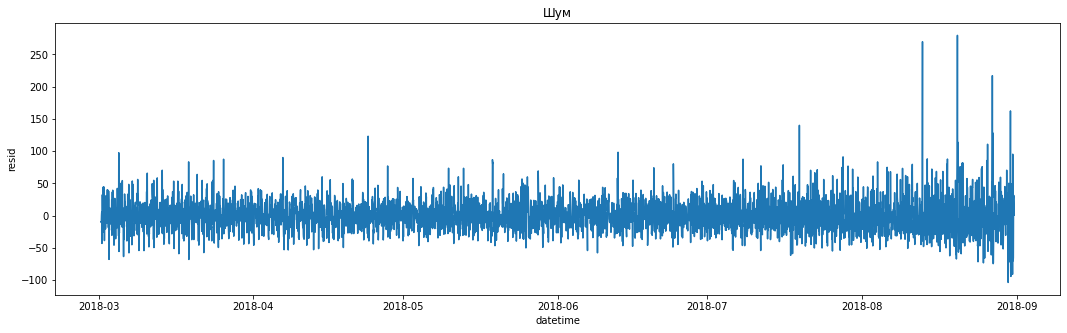

In [11]:
plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=decomposed.resid))
plt.title("Шум")
plt.show()

***Вывод:***  

- Общий тренд: увеличение количества заказов к осени
- Однотипная дневная сезонность: спрос на такси с утра и в обед, устойчивый рост спроса после 18:00 до 00:00

## Обучение

Для обучения выберем следующие модели:
- LinearRegression
- RandomForestRegressor
- LGBMRegressor  

Для каждой модели найдем гиперпараметры и посчитаем метрику RMSE для обучающей выборки.

### Подготовка признаков

Напишем функцию для формирования признаков.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data 

Применим данную функцию к наешму датасету с максимальным лагом в 4 и скользящим средним в 1.

In [13]:
data = df.copy()
data = make_features(data, 4, 1)
print(df.shape, data.shape)

(4416, 1) (4416, 10)


Сформируем выборки, размер тестовой выборки - 10% от начальных данных.

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3970, 9) (3970,)
(442, 9) (442,)


### Linear Regression

In [15]:
tss = TimeSeriesSplit(n_splits=2)

In [16]:
model = LinearRegression()
model.fit(features_train, target_train)
mse = cross_val_score(model, features_train, target_train, cv=tss, scoring='neg_mean_squared_error')
print("RMSE на кросс-валидации:", (-mse.mean()) ** 0.5)

RMSE на кросс-валидации: 33.18509125856495


### RandomForestRegressor

In [17]:
parameters = {'max_depth' : range(7,10), 'n_estimators' : range(10,13)}

model_rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(model_rf, parameters, cv=tss)
grid_rf.fit(features_train, target_train);

In [18]:
print("Лучшая модель:", grid_rf.best_estimator_)
mse = cross_val_score(grid_rf.best_estimator_, features_train, target_train, cv=tss, scoring='neg_mean_squared_error')
print("RMSE на кросс-валидации:", (-mse.mean()) ** 0.5)

Лучшая модель: RandomForestRegressor(max_depth=9, n_estimators=12, random_state=42)
RMSE на кросс-валидации: 30.38887004734722


### LightGBM¶

In [19]:
parameters = {'max_depth' : range(15,50,5)}

model_lgbm = LGBMRegressor(random_state=42)
grid_lgbm = GridSearchCV(model_lgbm, parameters, cv=tss)
grid_lgbm.fit(features_train, target_train);

In [20]:
print("Лучшая модель:", grid_lgbm.best_estimator_)
mse = cross_val_score(grid_lgbm.best_estimator_, features_train, target_train, cv=tss, scoring='neg_mean_squared_error')
print("RMSE на кросс-валидации:", (-mse.mean()) ** 0.5)

Лучшая модель: LGBMRegressor(max_depth=20, random_state=42)
RMSE на кросс-валидации: 29.573582361948258


***Вывод:*** лучшая модель - *LGBMRegressor(max_depth=20, random_state=42)*, c *RMSE на кросс-валидации: 29.57*

## Тестирование

Протестируем нашу лучшую модель.

In [21]:
pred = grid_lgbm.best_estimator_.predict(features_test)

rmse_test = mean_squared_error(target_test, pred, squared=False)
print("RMSE на тесте:", rmse_test)

RMSE на тесте: 43.49131896715006


***Вывод:*** значение RMSE на тестовой выборке ниже 48, что удовлетворяет условию задания.

In [22]:
result = target_test.to_frame().reset_index()
result['prediction'] = pd.Series(pred)
result.set_index('datetime', inplace=True)

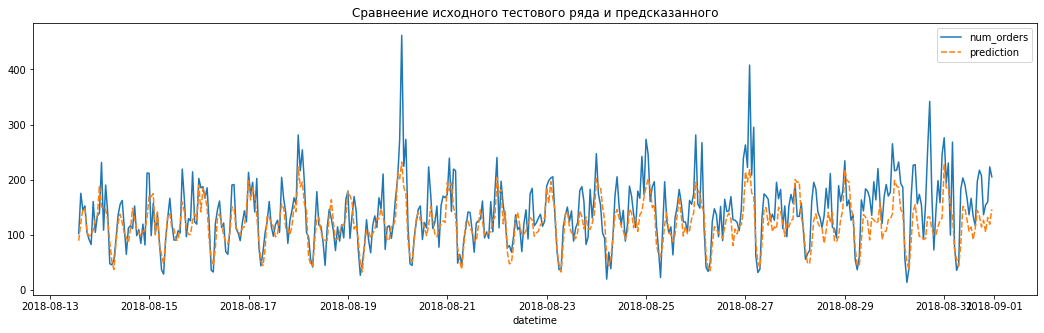

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(sns.lineplot(data=result))
plt.title("Сравнеение исходного тестового ряда и предсказанного")
plt.show()